In [3]:
from fslnet.fslnet import FSLNet
import torch

device = "cpu"  # o "cuda"
fslnet = FSLNet.from_pretrained(device=device)


In [5]:
from torchvision import datasets, transforms
import numpy as np

transform = transforms.ToTensor()

mnist = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

def get_digit(dataset, digit, n=1000):
    X = []
    for img, label in dataset:
        if label == digit:
            X.append(img.view(-1).numpy())
        if len(X) == n:
            break
    return np.stack(X)


100%|██████████| 9.91M/9.91M [00:03<00:00, 2.66MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 221kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.38MB/s]


In [11]:
ref_np = get_digit(mnist, digit=3)
que_np = get_digit(mnist, digit=8)

ref = torch.tensor(ref_np, dtype=torch.float32).to(device)
que = torch.tensor(que_np, dtype=torch.float32).to(device)

print(ref_np.shape)
print(que_np.shape)



(1000, 784)
(1000, 784)


In [7]:
with torch.no_grad():
    soft_predictions, _ = fslnet(ref, que)


In [8]:
P = soft_predictions.squeeze(0).cpu().numpy()


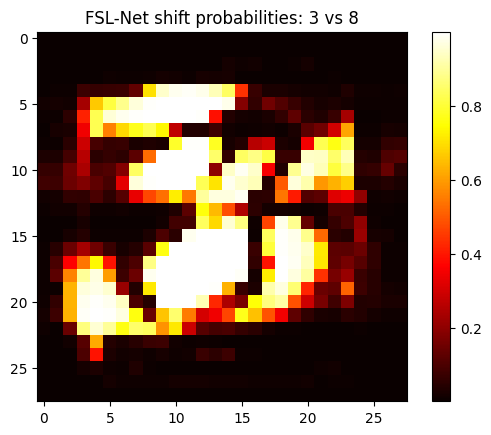

In [9]:
import matplotlib.pyplot as plt

plt.imshow(P.reshape(28, 28), cmap='hot')
plt.colorbar()
plt.title("FSL-Net shift probabilities: 3 vs 8")
plt.show()


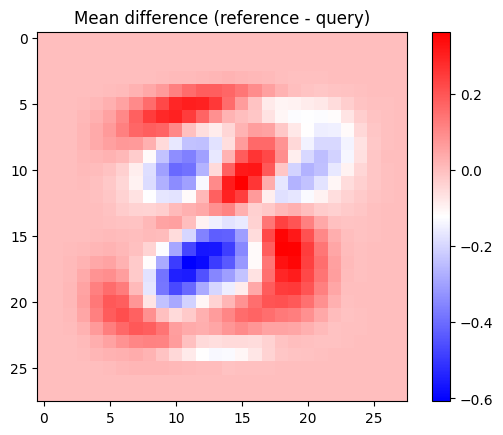

In [10]:
plt.imshow((ref_np.mean(0) - que_np.mean(0)).reshape(28,28), cmap='bwr')
plt.title("Mean difference (reference - query)")
plt.colorbar()
plt.show()
